# Plot bar chart comparing fluid compositions

In [1]:
%load_ext autoreload
%autoreload 2
%run ct_data.py '../crunchtope_model/hydrothermal_crunch.nc' -c pH totcon
%run pf_data.py '../pflotran_model/hydrothermal.nc'
%run figures.py
import cmcrameri.cm as cm
import numpy as np

Primary minerals: ['Anorthite', 'Albite', 'Diopside', 'Hedenbergite', 'Forsterite', 'Fayalite']
Secondary minerals: ['Tremolite', 'Prehnite', 'Talc', 'Quartz', 'Saponite_Mg', 'Epidote', 'Zoisite', 'Chamosite', 'Clinochlore', 'Analcime', 'Anhydrite', 'Calcite', 'Annite']
Primary mineral groups: {'olivine': ['Forsterite', 'Fayalite'], 'clinopyroxenes': ['Diopside', 'Hedenbergite'], 'plagioclases': ['Anorthite', 'Albite']}
Secondary mineral groups: {'clays': ['Saponite_Mg', 'Chamosite', 'Clinochlore'], 'zeolites': ['Analcime'], 'amphiboles': ['Tremolite'], 'inosilicates': ['Prehnite'], 'talc': ['Talc'], 'epidotes': ['Epidote', 'Zoisite'], 'sulfates': ['Anhydrite'], 'carbonates': ['Calcite'], 'quartz': ['Quartz'], 'mica': ['Annite']}


In [2]:
vent_fluid = {'H+': 6.31e-5, 'Mg++': 1.0e-12, 'Ca++': 40e-3, 'HCO3-': 2.0e-8, 'SO4--': 1e-6, 'SiO2(aq)': 2.02e-2}
seawater = {'H+': 10**(-8.15), 'Mg++': 0.0528, 'Ca++': 0.0103, 'HCO3-': 0.002, 'SO4--': 0.0282, 'SiO2(aq)': 0}

In [3]:
pf_data = pf_data.sel(file_number=6)


# Get CT values
model_vals_dict = ct_data['totcon'][vent_fluid.keys()].isel(file_num=6, X=-1).isel(time=-1).to_dict()
ct_vals = []

# Get ordered species data
for specie in vent_fluid.keys():
    if specie == 'H+':
        val = ct_data['pH'].isel(file_num=6, X=-1).isel(time=-1).to_dict()['data_vars']['pH']['data'][0][0]
        ct_vals.append(val)
    else:
        val = model_vals_dict['data_vars'][specie]['data'][0][0] * 1000
        ct_vals.append(val)
 # Put pH last
ct_vals.append(ct_vals.pop(0))

# Prepend 'Total_' to each key and return as a list
pf_keys = ['Total_' + key for key in vent_fluid.keys()]
pf_keys.remove('Total_H+')
pf_keys.append('pH')
pf_vals = pf_data.sel(x=0, z=1500, time=1000, method='nearest')[pf_keys]

# Convert values of each variable to a list
pf_dict = {var: pf_vals[var].values.tolist() for var in pf_vals.data_vars}
# Output the result
pf_values = list(pf_dict.values())
pf_values = np.array(pf_values) * 1000
pf_values = pf_values.flatten()
pf_values[-1] = pf_values[-1] / 1000

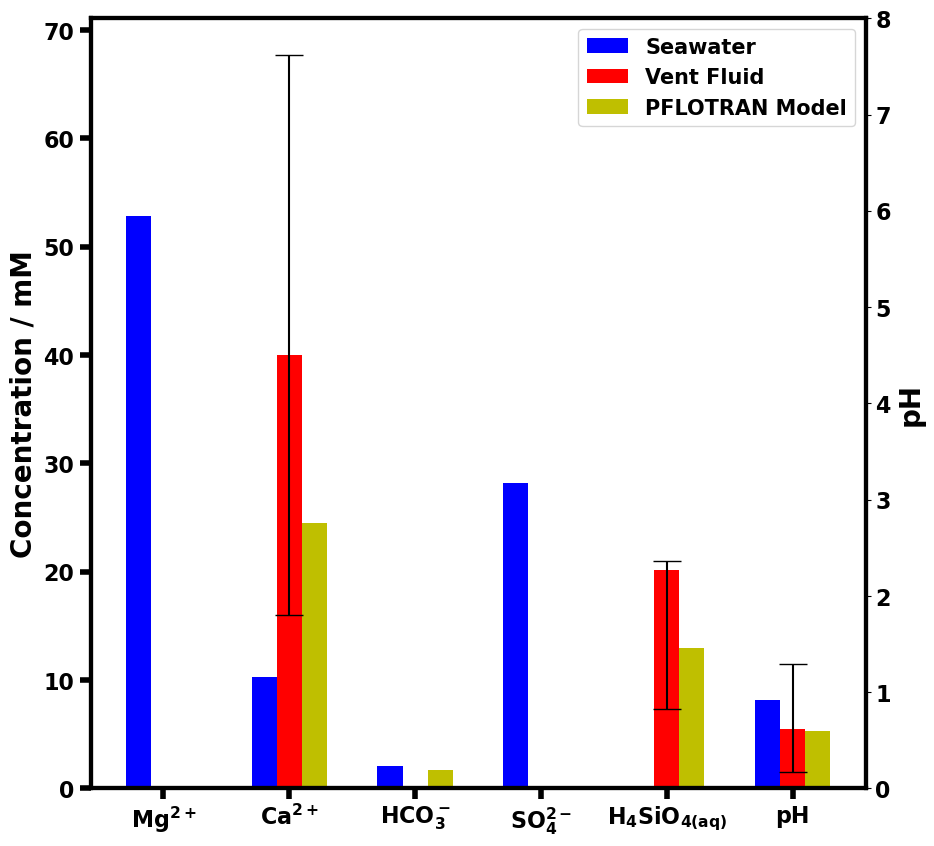

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

mpl.rcParams['axes.linewidth'] = 3
fig, ax = plt.subplots(figsize=(10,10))
ax.grid(False)
ax.tick_params(length=8, width=4)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontweight('bold')
    tick.label1.set_fontsize(16)
    tick.label2.set_fontweight('bold')
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontweight('bold')
    tick.label1.set_fontsize(16)
    tick.label2.set_fontweight('bold')

species = ['Mg$^{\mathbf{2+}}$', 'Ca$^{\mathbf{2+}}$', 'HCO$\mathbf{_3^-}$', 'SO$\mathbf{_4^{2-}}$', 'H$\mathbf{_4}$SiO$\mathbf{_{4(aq)}}$', 'pH']
penguin_means = {
    'Seawater': np.array([52.8, 10.3, 2.02, 28.2, 0, 8.15]),
    'Vent Fluid': np.array([0, 40, 0, 0, 20.2, 5.5]),
    'PFLOTRAN Model': np.array(pf_values)
}

limits = np.array([[0,0], [16, 67.7], [0,0], [0,0], [7.3, 21], [1.5, 11.5]])
limits = limits.transpose()
limits[0,:] = penguin_means['Vent Fluid'] - limits[0,:]
limits[1,:] = - penguin_means['Vent Fluid'] + limits[1,:]

x = np.arange(len(species))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

h = [None, None, None, None]
c = ['b', 'r', 'y', 'g']
for attribute_measurement, hatch, cols in zip(penguin_means.items(), h, c):
    attribute, measurement = attribute_measurement
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, color=cols, hatch=hatch)
    if attribute == 'Vent Fluid':
        ax.errorbar(x + offset, measurement, yerr=limits, fmt='none', c='k', capsize=10)
    multiplier += 1

ax2 = ax.twinx()
ax2.set_ylim(0, 8)
ax2.set_ylabel('pH', size=20, weight='bold')
for tick in ax2.yaxis.get_major_ticks():
    tick.label1.set_fontweight('bold')
    tick.label1.set_fontsize(20)
    tick.label2.set_fontsize(16)
    tick.label2.set_fontweight('bold')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Concentration / mM', size=20, weight='bold')
ax.set_xticks(x + width, species)
ax.legend(loc='upper right', ncols=1, prop={'weight': 'bold', 'size': 15})

fig.savefig('output/figure_s1.png', dpi=300)